# Task 4

This task asks us to train a sine function model. We first implemented this based on task 2 and an existing [Pennylane tutorial](https://pennylane.ai/blog/2021/10/how-to-start-learning-quantum-machine-learning/) and evaluated this model.

We then created our model, which can handle much more general curves, as we will explain. We then apply our model to the sum of a cosine curve and a sine curve, and discuss our result.

The following is implemented based on task 2 and the tutorial.

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

import matplotlib.pyplot as plt

np.random.seed(0)

In [3]:
X_train = np.linspace(0, 2*np.pi, 10)
Y_train = np.sin(X_train)
X_val = np.linspace(0, 2*np.pi, 1000)
Y_val = np.sin(X_val)

In [4]:
dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def quantum_circuit(params, datapoint):
    qml.RX(datapoint, wires=0)
    qml.Rot(params[0], params[1], params[2], wires=0)
    return qml.expval(qml.PauliZ(wires=0))

In [5]:
def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def cost(params, X_list, Y_list):
    predictions = [quantum_circuit(params, x)  for x in X_list]
    return square_loss(Y_list, predictions)


In [6]:
opt = qml.GradientDescentOptimizer(stepsize=0.3)

params = np.array([0.1,0.1,0.1],requires_grad=True)

for i in range (1000):
    params, _, _ = opt.step(cost, params, X_train, Y_train)
    if i%50 == 0:
        print(f'Step = {i}, Cost = {cost(params, X_train, Y_train)}')

Step = 0, Cost = 1.0008220305122786
Step = 50, Cost = 0.0007713203532094914
Step = 100, Cost = 0.00017248396195919063
Step = 150, Cost = 7.38963639111891e-05
Step = 200, Cost = 4.0810887949216756e-05
Step = 250, Cost = 2.583238372634074e-05
Step = 300, Cost = 1.780734986246756e-05
Step = 350, Cost = 1.3014033334755201e-05
Step = 400, Cost = 9.924375322652338e-06
Step = 450, Cost = 7.817236721627177e-06
Step = 500, Cost = 6.31625809478156e-06
Step = 550, Cost = 5.2094301198222625e-06
Step = 600, Cost = 4.3699318949256335e-06
Step = 650, Cost = 3.718128669912878e-06
Step = 700, Cost = 3.20197143604839e-06
Step = 750, Cost = 2.7862769323936345e-06
Step = 800, Cost = 2.4465707059739726e-06
Step = 850, Cost = 2.165401291431658e-06
Step = 900, Cost = 1.9300537696598063e-06
Step = 950, Cost = 1.7310868831418145e-06


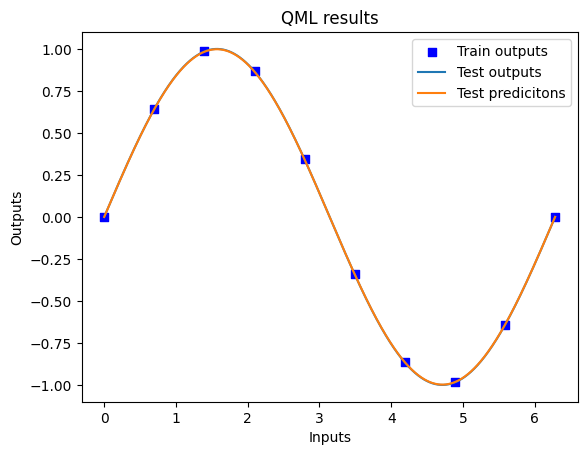

In [7]:
test_predictions =  [quantum_circuit(params, x)  for x in X_val]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train, Y_train, c='b', marker="s", label='Train outputs')
ax1.plot(X_val,Y_val, label='Test outputs')
ax1.plot(X_val,test_predictions, label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')
plt.show()

However, scrutinising the quantum ansatz,

```python
@qml.qnode(dev)
def quantum_circuit(params, datapoint):
    qml.RX(datapoint, wires=0)
    qml.Rot(params[0], params[1], params[2], wires=0)
    return qml.expval(qml.PauliZ(wires=0))
```

We see that this ansatz utilises a rotation around the X-axis, then a trainable rotation, then finds the expectation value of measuring along the Z-axis. Considering the Bloch Sphere, we realise that the RX gate essentially converts the original `datapoint` to `cos(datapoint)` when viewed in the Z-axis, i.e. creates a cosine curve. The trainable rotation simply translates or scales this cosine curve. 

The following graph shows some examples of the transformation. The lables are the parameters given to the `Rot` gate.


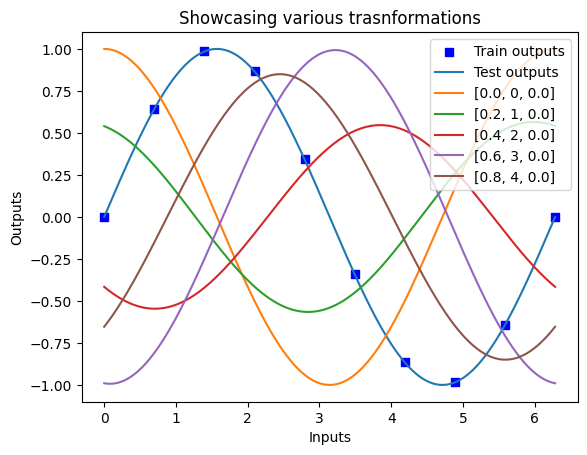

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train, Y_train, c='b', marker="s", label='Train outputs')
ax1.plot(X_val,Y_val, label='Test outputs')
for i in range(5):
    test_predictions = [quantum_circuit([i/5,i,0.0], x)  for x in X_val]
    ax1.plot(X_val,test_predictions, label=str([i/5,i,0.0]))

plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("Showcasing various trasnformations")

plt.legend(loc='upper right')
plt.show()

In [11]:
print(f'phi, theta, omega = {params[0]}, {params[1]}, {params[2]}')
print(f'phi, theta, omega (in degrees) = {params[0]/np.pi * 180}, {params[1]/np.pi * 180}, {params[2]/np.pi * 180}')

phi, theta, omega = -1.5097197879042852, 1.5707963267948966, 0.09999999999999999
phi, theta, omega (in degrees) = -86.50057209430133, 90.0, 5.729577951308232


Consider the `Rot` gate $R(\phi, \theta, \omega) = RZ(\omega)RZ(\theta)RZ(\phi)$. The final expectation value is calculated along the Z axis, thus the final $RZ(\omega)$ rotation does not affect our measurement. The other rotations approximate to a $-\frac{\pi}{2}$ rotation around the Z axis followed by a $\frac{\pi}{2}$ rotation around the Y axis. Considering the Bloch sphere, this essentially is a transformation from measuring the cosine to measuring the sine component (the Bloch Sphere is a unit sphere, the hypotenuse is always 1).

Given that our ansatz directly converts the `X` data into its cosine, and only the transformation from the cosine to the sine function is trained, this is equivalent to simply curve-fitting a known equation to fit our data. The issue here is that the quantum model is far too restrictive. 

The following is our implement of the quantum circuit and layers.

In [71]:
num_layers = 3
bias_init = np.array([1.0, 0.0], requires_grad=True)
weights_init = 0.01 * np.random.randn(num_layers, 2, 3, requires_grad=True)

Firstly, we use a two-qubit system instead of one. This allows us to create entanglement, further utilising quantum properities.

During the encoding of our inputs, we also give the inputs some weights so they they can affect the two qubits differently, which gives our model another degree of freedom. By incorporating layers, we can increase the number of parameters as we like by adding more layers, further generalising our model.

We also have an additional bias trainable variable. Expectation values must have values between -1 to 1, thus this additional bias variable will allow our model to fit over a larger range of values.


In [54]:
dev = qml.device('default.qubit', wires=2)

def layer(layer_weights):
        for wire in range(2):
            qml.Rot(*layer_weights[wire], wires=wire)
        qml.CNOT(wires=[0, 1])


@qml.qnode(dev)
def our_circuit(weights, x):
    qml.Rot(*(weights[0][0] * x), wires=0)
    qml.Rot(*(weights[0][1] * x), wires=1)

    for layer_weights in weights[1:]:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0)) 

In [96]:
def predictions(weights, bias, X_list):
    predictions = [our_circuit(weights, x) * bias[0] + bias[1] for x in X_list]
    return predictions

def our_cost(weights,bias, X_list, Y_list):
    predictions = predictions(weights, bias, X_list)
    return square_loss(Y_list, predictions)

In [31]:
opt = qml.AdamOptimizer(stepsize=0.01)

weights = weights_init
bias = bias_init
for i in range (1000):
    weights, _, _ = opt.step(our_cost, weights, bias, X_train, Y_train)
    if i%50 == 0:
        print(f'Step = {i}, Cost = {our_cost(weights, bias, X_train, Y_train)}')

Step = 0, Cost = 1.4398646802255828
Step = 50, Cost = 0.21063392607177644
Step = 100, Cost = 0.19088685278121334
Step = 150, Cost = 0.12825190217208765
Step = 200, Cost = 0.008033048070340679
Step = 250, Cost = 0.0034961562818489832
Step = 300, Cost = 0.0022583132047646302
Step = 350, Cost = 0.0015053655673591814
Step = 400, Cost = 0.0008933808302731114
Step = 450, Cost = 0.0003467166574829587
Step = 500, Cost = 6.99000588623367e-05
Step = 550, Cost = 1.5642181621626982e-05
Step = 600, Cost = 5.22845943486537e-06
Step = 650, Cost = 2.1915873405991646e-06
Step = 700, Cost = 1.0390786440395056e-06
Step = 750, Cost = 5.309980808466406e-07
Step = 800, Cost = 2.8511453111858833e-07
Step = 850, Cost = 1.584768428349823e-07
Step = 900, Cost = 9.034619839483468e-08
Step = 950, Cost = 5.25096806165493e-08


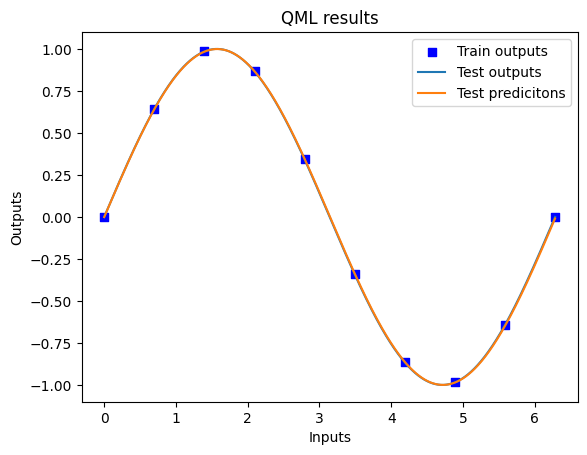

In [32]:
test_predictions = predictions(weights, bias, X_val)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train, Y_train, c='b', marker="s", label='Train outputs')
ax1.plot(X_val, Y_val, label='Test outputs')
ax1.plot(X_val, test_predictions, label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')
plt.show()

We see above that our model, given the right optimizer, is able to model the sine curve closely.

In the following, we change the step size and our model has more difficulty converging. The beauty of this graph is that it shows how flexible our model is, compared to the original tutorial model.

In [94]:
opt = qml.AdamOptimizer(stepsize=0.5)

weights = weights_init
bias = bias_init
for i in range (1000):
    weights, bias, _, _ = opt.step(our_cost, weights, bias, X_train, Y_train)
    if i%50 == 0:
        print(f'Step = {i}, Cost = {our_cost(weights, bias, X_train, Y_train)}')

Step = 0, Cost = 0.5515708543696265
Step = 50, Cost = 0.1147865123788736
Step = 100, Cost = 0.009332385637748044
Step = 150, Cost = 0.002529680737566664
Step = 200, Cost = 0.005684732359976113
Step = 250, Cost = 0.04703155512603089
Step = 300, Cost = 0.02375148423274168
Step = 350, Cost = 0.0027613287162768377
Step = 400, Cost = 0.6489518486255799
Step = 450, Cost = 0.1451770615267272
Step = 500, Cost = 0.027190893487343337
Step = 550, Cost = 0.029837301289287438
Step = 600, Cost = 0.0170599577981483
Step = 650, Cost = 0.018201742422177414
Step = 700, Cost = 0.016332328860630387
Step = 750, Cost = 0.03139395306927473
Step = 800, Cost = 0.017374111678202266
Step = 850, Cost = 0.05254208162158873
Step = 900, Cost = 0.1296326590905313
Step = 950, Cost = 0.1302051235068456


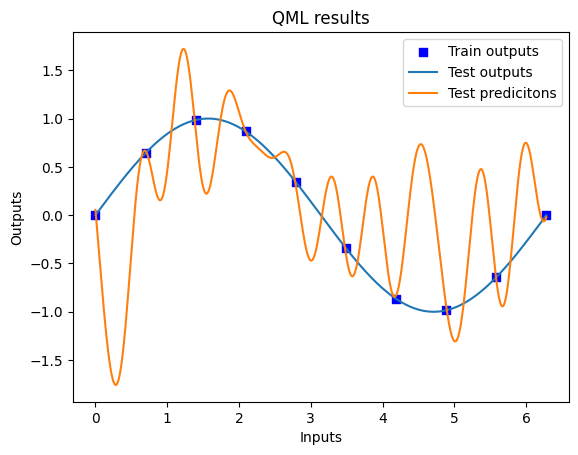

In [95]:
test_predictions =  predictions(weights, bias, X_val) 

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train, Y_train, c='b', marker="s", label='Train outputs')
ax1.plot(X_val, Y_val, label='Test outputs')
ax1.plot(X_val, test_predictions, label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')

We see above that our model has a high degree of freedom. We can further test how our model performs on the summation of a sin and cosine graph,

$$y = 0.3 \sin{2x} + 0.7 \cos{3x}$$

In [92]:
X_train_fourier = np.linspace(0, 2*np.pi, 25)
Y_train_fourier = 0.3 * np.sin(2 * X_train_fourier) + 0.7 * np.cos(3* X_train_fourier)
X_val_fourier = np.linspace(0, 2*np.pi, 1000)
Y_val_fourier = 0.3 * np.sin(2 * X_val_fourier) + 0.7 * np.cos(3 * X_val_fourier)

opt = qml.AdamOptimizer(stepsize=0.01)

weights_fourier = weights_init
bias_fourier = bias_init
for i in range (1000):
    weights_fourier, bias_fourier, _, _ = opt.step(our_cost, weights_fourier, bias_fourier, X_train_fourier, Y_train_fourier)
    if i%50 == 0:
        print(f'Step = {i}, Cost = {our_cost(weights_fourier, bias_fourier, X_train_fourier, Y_train_fourier)}')



Step = 0, Cost = 1.197345672273771
Step = 50, Cost = 0.2967359467546907
Step = 100, Cost = 0.2855034598544104
Step = 150, Cost = 0.2709292193417003
Step = 200, Cost = 0.25879157049417517
Step = 250, Cost = 0.2320235925805314
Step = 300, Cost = 0.1593980230305502
Step = 350, Cost = 0.10213618808932333
Step = 400, Cost = 0.07077112860557234
Step = 450, Cost = 0.04619456171446687
Step = 500, Cost = 0.027553550328071767
Step = 550, Cost = 0.01047026636927866
Step = 600, Cost = 0.005336080390938398
Step = 650, Cost = 0.002756129999030911
Step = 700, Cost = 0.0013895429224928938
Step = 750, Cost = 0.0008084691964907946
Step = 800, Cost = 0.0006216107198567996
Step = 850, Cost = 0.0006482414318209018
Step = 900, Cost = 0.0005877609684921567
Step = 950, Cost = 0.0005709473112714947


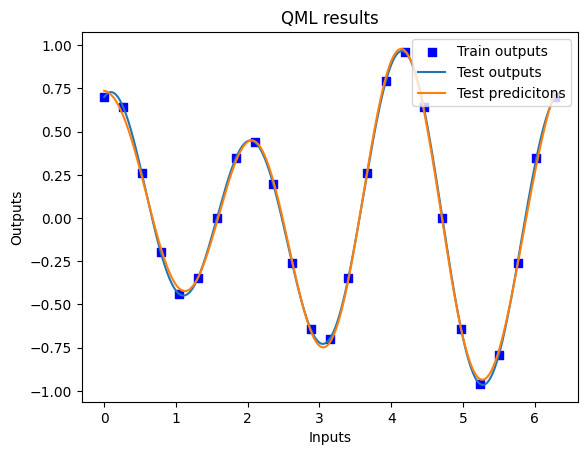

In [97]:
test_predictions_fourier = predictions(weights_fourier, bias_fourier, X_val_fourier) 

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train_fourier, Y_train_fourier, c='b', marker="s", label='Train outputs')
ax1.plot(X_val_fourier, Y_val_fourier, label='Test outputs')
ax1.plot(X_val_fourier, test_predictions_fourier, label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')
plt.show()

We see here that our model does a reasonable job of modeling this summed graph. Considering that any periodic function can be expanded in terms of an infinite sum of sines and cosines, or approximated using a finite sum of these functions, we postulate that our quantum model can offer advantages when learning periodic function due to the nature of quantum mechanics, and may have applications in the field of Fourier series and Fourier transforms.